In [1]:
import matplotlib.pyplot as plt         # import matplotlib
from matplotlib.widgets import Slider
import numpy as np                      # import numpy
import ipywidgets as widgets            # interactive display

# setting for figures
fig_w, fig_h = 8, 6
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)
my_layout = widgets.Layout()

# Auto Reloading
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [ ]:
import os, sys

# clone respository
user = "michaelglh"
repo = "STG"
if os.path.isdir(repo):
    !rm -rf {repo}
!git clone https://github.com/{user}/{repo}.git

# add path to system
src_dir = ""
path = f"{repo}/{src_dir}"
if not path in sys.path:
    sys.path.insert(1, path)

### Network of LIFs

interactive(children=(Output(),), _dom_classes=('widget-interact',))

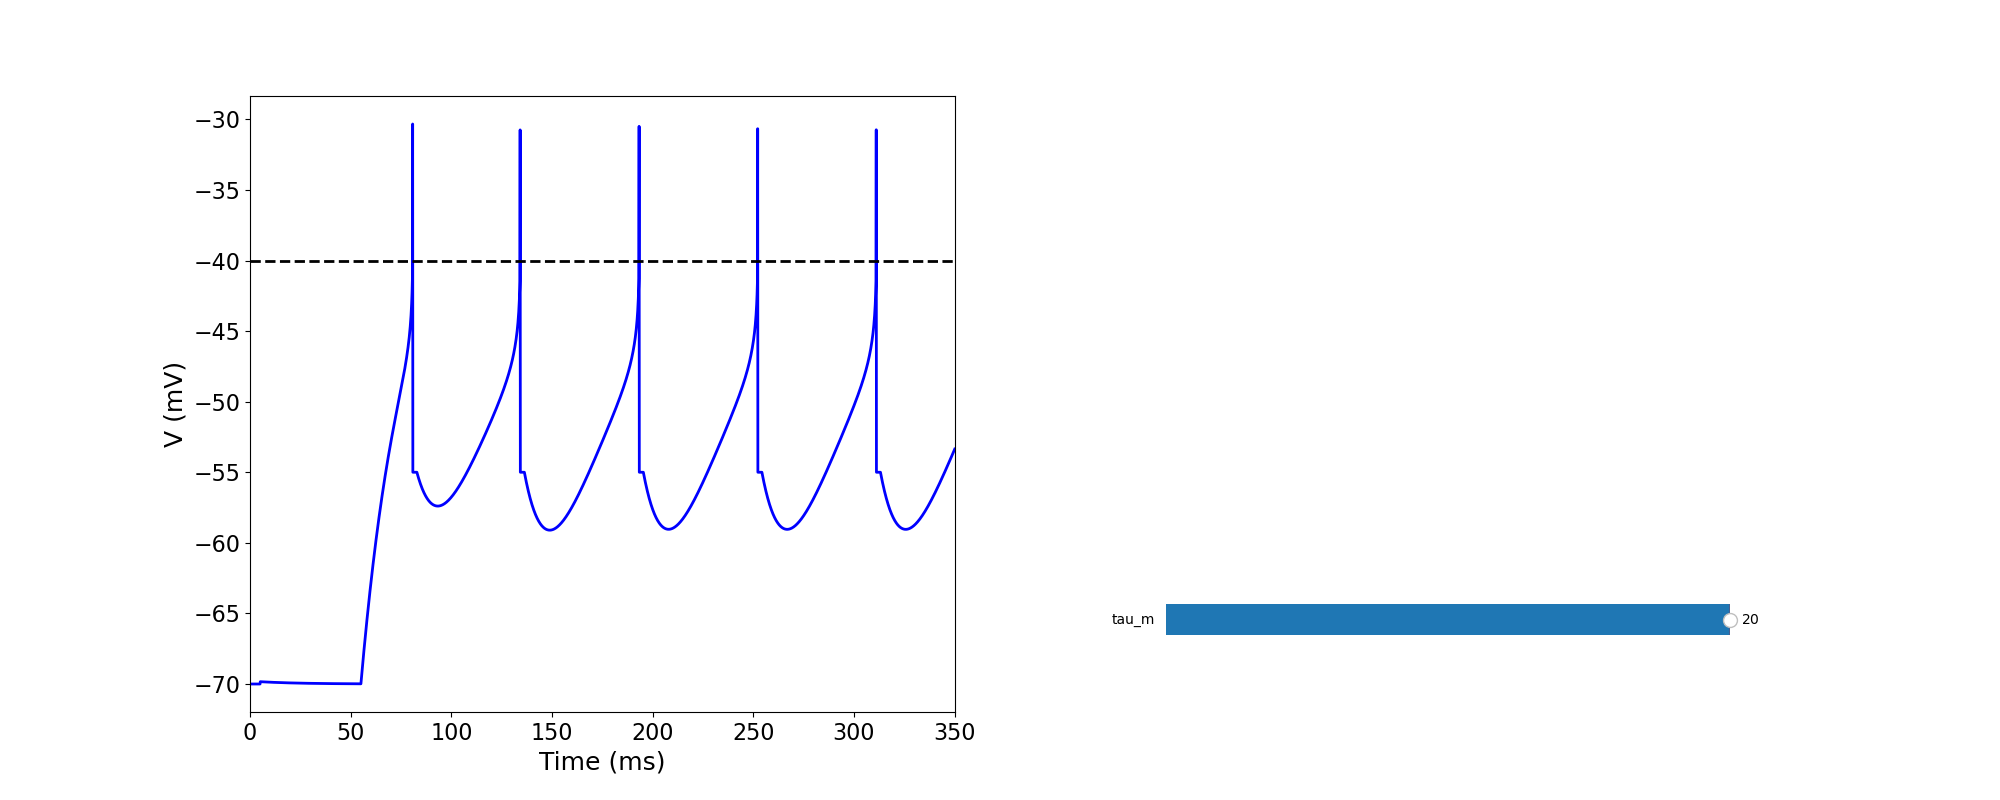

In [12]:
from lib.neuron import LIF
from lib.input import Poisson_generator, Gaussian_generator, Current_injector
from lib.conn import Simulator
from lib.helper import plot_volt_trace

T, dt = 5e2, 0.1    # simulation period(ms), step size(ms)
wt, dl = 1., 5.
rt = 65.

# simualtor
h = Simulator(dt=dt)

# neurons
nrn = LIF(sim=h)
nrn.g_L = 2.
nrn.E_L = -70.
nrn.V_th = -40.

# tonic
nrn.tau_m = 20.
nrn.tau_w = 30.
nrn.b = 3
nrn.V_reset = -55.

# # adpating
# nrn.tau_m = 20.
# nrn.tau_w = 100.
# nrn.b = 0.5
# nrn.V_reset = -55.

# # initial bursting
# nrn.tau_m = 10.
# nrn.tau_w = 100.
# nrn.b = 1.
# nrn.V_reset = -51.

# # bursting
# nrn.tau_m = 5.
# nrn.tau_w = 100.
# nrn.b = 1
# nrn.V_reset = -46.

# # irregular
# nrn.tau_m = 9.9
# nrn.a = -0.01
# nrn.tau_w = 50.
# nrn.b = 1.2
# nrn.V_reset = -46.

# # transient
# nrn.tau_m = 5.
# nrn.a = 0.05
# nrn.tau_w = 100.
# nrn.b = 0.7
# nrn.V_reset = -60.

# # delayed
# nrn.tau_m = 5.
# nrn.a = -0.1
# nrn.tau_w = 100.
# nrn.b = 1.0
# nrn.V_reset = -60.
# rt = 5.

# constant current injection
Is = np.concatenate([np.zeros(int(T/dt*0.1)), rt*np.ones(int(T/dt*0.9))])
cur_in = Current_injector(sim=h, Is=Is)

# connecting inputs to neurons
nrn.connect(cur_in, {'ctype':'static', 'weight': wt, 'delay':dl})

# simulate
h.run(T)

# visualize
fig, axes = plt.subplots(1,2, figsize=(20,8))
ax_fig, ax_par = axes[0], axes[1]

# slider bars for different parameters
ax_par.axis('off')
tau_m = Slider(ax_par.inset_axes([0.1, 0.1, 0.8, 0.1]), 'tau_m', 5., 20., 20.)
 
# updating parameters
def update():
    # update value
    nrn.tau_m = tau_m.val
    print(nrn.tau_m)

    # simulate
    h.run(T)

    # visualize
    plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':nrn.V_th}
    plot_volt_trace(plt_par, nrn.v, np.array(nrn.rec_spikes), axis=ax_fig)
    ax_fig.set_xlim([0, 350])

tau_m.on_changed(update);
widgets.interact(update);

In [ ]:
# Poisson spike train inputs
Is = np.concatenate([np.zeros(int(T/dt*0.1)), rt*np.ones(int(T/dt*0.9))])
cur_in = Current_injector(sim=h, Is=Is)
# exc_in = Poisson_generator(sim=h, rate=rt)  # rt: poisson spike train rate
# inh_in = Poisson_generator(sim=h, rate=rt)

# connecting inputs to neurons
nrn.connect(cur_in, {'ctype':'static', 'weight': wt, 'delay':dl})
# nrn.connect(exc_in, {'ctype':'static', 'weight': wt, 'delay':dl})
# nrn.connect(exc_in, {'ctype':'facilitate', 'weight': wt, 'delay':dl})
# nrn.connect(exc_in, {'ctype':'depress', 'weight': wt, 'delay':dl})
# nrn.connect(inh_in, {'weight': -wt, 'delay':dl})

In [ ]:
T, dt = 1e3, 0.1        # simulation period(ms), step size(ms)
N = 10                  # number of neurons
mean, std = 200., 40.   # background noise
wt, dl = 1., 5.

# simualtor
h = Simulator(dt=dt)

# network of neurons
nrns = [LIF(sim=h) for _ in range(N)]

# background noise
noises = [Gaussian_generator(sim=h, mean=mean, std=std) for _ in range(N)]
for noise, nrn in zip(noises, nrns):
    nrn.connect(noise, {'ctype':'static', 'weight':wt, 'delay':dl})

# recurrent connections
p, w = 0.5, -1 # connection probability, connection strength
tps = [['facilitate']*N]*N
# tps = [['static']*N]*N
con = np.random.rand(N,N)*(np.random.rand(N,N)< p)*w
dly = np.random.uniform(2., 5., (N,N))
synspecs = [[{} for _ in range(N)] for _ in range(N)]
for i in range(N):
    for j in range(N):
        synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
h.connect(nrns, nrns, synspecs)  # random recurrent inhibition with probablity p, strength w and delay between 2 to 5 ms

# simulation
h.run(T)

# visualize
plt.subplots(1,2,figsize=(12,5))
plt.subplot(1,2,1)
plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':-55.}
plot_volt_trace(plt_par, nrns[0].v, np.array(nrns[0].rec_spikes))

# raster plots of population
spike_trains = [nrn.rec_spikes for nrn in nrns]
plt.subplot(1,2,2)
plt.eventplot(spike_trains);
plt.xlabel('Time(ms)')
plt.ylabel('Idx')